In [203]:
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

from scipy.sparse import csr_matrix

plt.style.use('default')
sns.set_style("whitegrid")

# Content-Based News Recommendation System

## 1. Dataset Loading

In [204]:
# Load dataset
notebook_dir = Path(os.getcwd())
data_root = notebook_dir / 'MINDsmall_train'

news = pd.read_csv(
    data_root / 'news.tsv',
    sep='\t',
    header=None,
    names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'],
    on_bad_lines='skip'
)

behaviors = pd.read_csv(
    data_root / 'behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

print(f"Dataset: {len(news):,} articles, {len(behaviors):,} impressions, {behaviors['user_id'].nunique():,} users")

Dataset: 51,282 articles, 156,965 impressions, 50,000 users


In [205]:
# Dataset statistics
print(f"Articles: {len(news):,}, Categories: {news['category'].nunique()}")
print(f"Impressions: {len(behaviors):,}, Users: {behaviors['user_id'].nunique():,}")
print(f"Missing abstracts: {news['abstract'].isna().sum()}")


Articles: 51,282, Categories: 17
Impressions: 156,965, Users: 50,000
Missing abstracts: 2666


## 2. Data Preprocessing

In [206]:
# Combine title and abstract
news['text'] = news['title'].fillna('') + ' ' + news['abstract'].fillna('')
news = news[news['text'].str.strip() != ''].copy()
print(f"Articles with valid text: {len(news):,}")

Articles with valid text: 51,282


In [207]:
def parse_impressions(impression_str):
    """Parse impression string format: 'N123-1 N456-0' -> (items, labels)"""
    if pd.isna(impression_str) or impression_str == '':
        return [], []
    items, labels = [], []
    for pair in str(impression_str).split():
        try:
            nid, lbl = pair.split('-')
            items.append(nid)
            labels.append(int(lbl))
        except ValueError:
            continue
    return items, labels

# Parse impressions
behaviors['imp_items'], behaviors['imp_labels'] = zip(
    *behaviors['impressions'].apply(parse_impressions)
)

# Calculate click statistics
total_impressions = behaviors['imp_items'].apply(len).sum()
total_clicks = behaviors['imp_labels'].apply(sum).sum()
click_rate = total_clicks / total_impressions if total_impressions > 0 else 0

print(f"Impressions: {total_impressions:,}, Clicks: {total_clicks:,}, Click rate: {click_rate:.2%}")

Impressions: 5,843,444, Clicks: 236,344, Click rate: 4.04%


## 3. Build User Click Histories

In [208]:
# Build user click history
user_clicked = {}
for _, row in behaviors.iterrows():
    uid = row['user_id']
    clicked = [item for item, label in zip(row['imp_items'], row['imp_labels']) if label == 1]
    if uid not in user_clicked:
        user_clicked[uid] = []
    user_clicked[uid].extend(clicked)

# Remove duplicates
for uid in user_clicked:
    user_clicked[uid] = list(dict.fromkeys(user_clicked[uid]))

click_counts = [len(clicks) for clicks in user_clicked.values()]
print(f"Users: {len(user_clicked):,}, Average clicks per user: {np.mean(click_counts):.2f}, Median: {np.median(click_counts):.1f}")

# Build article popularity for cold-start fallback
article_popularity = {}
for _, row in behaviors.iterrows():
    for item, label in zip(row['imp_items'], row['imp_labels']):
        if label == 1:
            article_popularity[item] = article_popularity.get(item, 0) + 1

if article_popularity:
    max_pop = max(article_popularity.values())
    article_popularity = {k: v / max_pop for k, v in article_popularity.items()}
print(f"Articles with popularity scores: {len(article_popularity):,}")

Users: 50,000, Average clicks per user: 4.69, Median: 3.0
Articles with popularity scores: 7,713


## 4. TF-IDF Vectorization

In [209]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    stop_words='english',
    ngram_range=(1, 2)
)

news_tfidf = vectorizer.fit_transform(news['text'])
news_index = {nid: i for i, nid in enumerate(news['news_id'])}

print(f"TF-IDF shape: {news_tfidf.shape}, Vocabulary: {len(vectorizer.vocabulary_):,}")


TF-IDF shape: (51282, 5000), Vocabulary: 5,000


## 5. User Profile Construction

In [210]:
def get_user_vector(user_id):
    """Build user profile by averaging TF-IDF vectors of clicked articles."""
    clicked = user_clicked.get(user_id, [])
    idxs = [news_index[n] for n in clicked if n in news_index]
    if len(idxs) == 0:
        return None
    profile = news_tfidf[idxs].mean(axis=0)
    return np.asarray(profile).flatten()

## 6. Scoring and Ranking

In [211]:
def score_impression(impression_row):
    """Score articles using cosine similarity to user profile + popularity fallback."""
    uid = impression_row['user_id']
    items = impression_row['imp_items']
    uvec = get_user_vector(uid)
    scores = np.zeros(len(items))
    
    # Content-based scoring
    if uvec is not None:
        idxs, positions = [], []
        for i, news_id in enumerate(items):
            if news_id in news_index:
                idxs.append(news_index[news_id])
                positions.append(i)
        
        if idxs:
            item_vecs = news_tfidf[idxs]
            content_sims = cosine_similarity(uvec.reshape(1, -1), item_vecs).flatten()
            for pos, sim in zip(positions, content_sims):
                scores[pos] = sim
    
    # Popularity fallback
    for i, news_id in enumerate(items):
        pop_score = article_popularity.get(news_id, 0.0)
        if scores[i] == 0:
            scores[i] = pop_score * 0.5
        else:
            scores[i] = scores[i] * 0.9 + pop_score * 0.1
    
    return scores

## 7. Evaluation

In [212]:
def evaluate_recommendations(behaviors_df, sample_size=None, random_seed=42):
    """Evaluate recommendation system using multiple metrics."""
    eval_df = behaviors_df.sample(n=min(sample_size, len(behaviors_df)), random_state=random_seed) if sample_size else behaviors_df.copy()
    
    hits_at_1 = 0
    reciprocal_ranks = []
    ndcg_scores = []
    auc_scores = []
    total_evaluated = 0
    
    for _, row in eval_df.iterrows():
        scores = score_impression(row)
        labels = np.array(row['imp_labels'])
        
        if sum(labels) == 0 or np.all(scores == 0):
            continue
        
        total_evaluated += 1
        
        try:
            auc_scores.append(roc_auc_score(labels, scores))
        except ValueError:
            pass
        
        ranked_indices = np.argsort(scores)[::-1]
        
        if labels[ranked_indices[0]] == 1:
            hits_at_1 += 1
        
        clicked_ranks = [i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1]
        if clicked_ranks:
            reciprocal_ranks.append(1.0 / clicked_ranks[0])
        
        top_5_indices = ranked_indices[:5]
        dcg = sum((labels[idx] / np.log2(i + 2)) for i, idx in enumerate(top_5_indices))
        ideal_ranks = sorted([i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1])[:5]
        idcg = sum(1.0 / np.log2(rank + 1) for rank in ideal_ranks)
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0.0)
    
    return {
        'Hit Rate @ 1': hits_at_1 / total_evaluated if total_evaluated > 0 else 0.0,
        'MRR': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'NDCG @ 5': np.mean(ndcg_scores) if ndcg_scores else 0.0,
        'AUC': np.mean(auc_scores) if auc_scores else 0.0,
        'Coverage': total_evaluated / len(eval_df) if len(eval_df) > 0 else 0.0,
        'Total Evaluated': total_evaluated
    }

# Evaluate on training set
train_metrics = evaluate_recommendations(behaviors, sample_size=None, random_seed=42)
print("Training Set Results:")
for metric, value in train_metrics.items():
    if metric == 'Total Evaluated':
        print(f"  {metric}: {value:,}")
    elif metric == 'Coverage':
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")

Training Set Results:
  Hit Rate @ 1: 0.8308
  MRR: 0.9061
  NDCG @ 5: 0.9887
  AUC: 0.9869
  Coverage: 100.00%
  Total Evaluated: 156,965


## 8. Generate Recommendations

In [213]:
def recommend_for_user(user_id, top_k=5, exclude_clicked=True):
    """Generate top-k recommendations for a user."""
    uvec = get_user_vector(user_id)
    if uvec is None:
        return pd.DataFrame({'news_id': [], 'title': [], 'category': []})
    
    sims = cosine_similarity(uvec.reshape(1, -1), news_tfidf).flatten()
    top_indices = sims.argsort()[::-1][:top_k * 2]
    
    if exclude_clicked:
        clicked = set(user_clicked.get(user_id, []))
        top_indices = [idx for idx in top_indices if news.iloc[idx]['news_id'] not in clicked][:top_k]
    else:
        top_indices = top_indices[:top_k]
    
    if len(top_indices) == 0:
        return pd.DataFrame({'news_id': [], 'title': [], 'category': []})
    
    recommendations = news.iloc[top_indices][['news_id', 'title', 'category']].copy()
    recommendations['similarity_score'] = sims[top_indices]
    return recommendations

## 9. Results and Evaluation


### 9.1 Experimental Setup

**Data Division: Training and Testing Sets**

We followed the standard train-dev split provided by the MIND dataset:

- **Training Set (MINDsmall_train)**: 
  - 51,282 news articles, 156,965 impressions, 50,000 users
  - Used for: Building TF-IDF vectorizer, constructing user profiles

- **Development Set (MINDsmall_dev)**:
  - 42,416 news articles, 73,152 impressions, 50,000 users
  - Used for: Evaluating generalization performance

**Why This Setup?**

1. **Temporal Validity**: Simulates real-world deployment where we train on historical data and evaluate on future impressions.

2. **Prevents Data Leakage**: 
   - User profiles built only from training data
   - TF-IDF vectorizer fitted only on training articles
   - Tests true generalization to unseen articles and users

3. **Cold-Start Evaluation**: Dev set contains new articles (67.1% overlap) and mostly new users (11.9% overlap), testing content-based filtering's ability to handle cold-start scenarios.

4. **Feature Space Consistency**: Same TF-IDF vectorizer (fitted on training) transforms dev articles, ensuring consistent vocabulary and realistic production simulation.


### 9.2 Evaluation Metrics

**Metrics Chosen and Justification**

We evaluate using four metrics capturing different aspects of recommendation quality:

1. **Hit Rate @ 1 (HR@1)**: Percentage of impressions where the top-ranked article was clicked
   - Measures ability to identify the single most relevant article
   - Critical for email recommendations where first item is most visible

2. **Mean Reciprocal Rank (MRR)**: Average of 1/rank of first clicked item
   - Captures ranking quality, rewarding systems that place clicked items higher
   - More nuanced than HR@1 as it considers position of first click

3. **NDCG @ 5**: Normalized Discounted Cumulative Gain at position 5
   - Accounts for multiple clicked items (not just first)
   - Applies position discount (top items matter more)
   - Normalized for comparison across impression sizes

4. **Coverage**: Percentage of users that can receive recommendations
   - Measures system's ability to serve all users, including cold-start cases

**Are These Metrics Reflective Enough?**

**Strengths:**
- Comprehensive: Cover accuracy (HR@1, MRR), ranking quality (NDCG@5), and coverage
- Industry standard and align with real-world success metrics

**Limitations:**
- Don't measure diversity (category/entity diversity in recommendations)
- Don't capture novelty (introducing users to new topics)
- Don't consider temporal aspects (recency, freshness)
- Offline metrics may not perfectly correlate with user satisfaction

**Conclusion**: These metrics provide a solid foundation, but could be enhanced with diversity, novelty, and recency metrics for a more complete evaluation.


### 9.3 Results and Comparison

**Training Set Results** (73,152 impressions evaluated):
- **Hit Rate @ 1**: 0.8300 (83.00%)
- **MRR**: 0.9057
- **NDCG @ 5**: 0.9888
- **AUC**: 0.9871
- **Coverage**: 100%

**Dev Set Results** (67,964 impressions evaluated):
- **Hit Rate @ 1**: 0.1056 (10.56%)
- **MRR**: 0.2513
- **NDCG @ 5**: 0.3496
- **AUC**: 0.5386
- **Coverage**: 92.91%

**Performance Gap Analysis:**

| Metric | Train | Dev | Difference | Relative Drop |
|--------|-------|-----|------------|---------------|
| Hit Rate @ 1 | 0.8300 | 0.1056 | 0.7244 | 87.3% |
| MRR | 0.9057 | 0.2513 | 0.6544 | 72.3% |
| NDCG @ 5 | 0.9888 | 0.3496 | 0.6392 | 64.6% |
| AUC | 0.9871 | 0.5386 | 0.4485 | 45.4% |

**Discussion of Results:**

**Training Performance:**
- Strong performance (HR@1: 83%) demonstrates content-based filtering effectively captures user preferences through TF-IDF similarity
- High MRR (0.91) indicates clicked articles appear early in rankings
- 100% coverage shows all users can receive recommendations

**Dev Performance and Generalization:**
- **Significant performance drop** indicates the model struggles to generalize to dev set
- **Root Causes:**
  1. **User overlap**: Only 11.9% of dev users have training history, causing cold-start issues
  2. **Article overlap**: 67.1% article overlap means 32.9% are completely new, but user profiles built from training may not match dev article distribution
  3. **Distribution shift**: Dev set may have different user behavior patterns or article characteristics

**Key Insights:**
- Content-based filtering works well when user profiles are built from same data distribution
- Performance degrades significantly when evaluating on different user populations (cold-start)
- The approach handles new articles reasonably (via content similarity) but struggles with new users

**Comparison with Baselines:**
- **Random baseline**: HR@1 ≈ 2.7% (1/37 articles). Dev performance (10.56%) is ~4x better, but still low
- **Popularity baseline**: Would achieve higher coverage but lower personalization
- **Expected performance**: The large train-dev gap suggests overfitting to training user patterns

**Limitations:**
1. **Cold-start problem**: New users (88.1% of dev set) cannot be effectively served
2. **Filter bubble**: Recommendations are very similar to past clicks, limiting diversity
3. **Temporal aspects**: Doesn't consider recency, trending topics, or time-based preferences

**Conclusion**: While content-based filtering shows promise on training data, the significant dev performance drop highlights the need for better cold-start handling and hybrid approaches combining content-based and collaborative filtering.


## 11. Validation on Dev Dataset


In [214]:
# Load dev dataset
dev_data_root = notebook_dir / 'MINDsmall_dev'
dev_news = pd.read_csv(
    dev_data_root / 'news.tsv',
    sep='\t',
    header=None,
    names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'],
    on_bad_lines='skip'
)
dev_behaviors = pd.read_csv(
    dev_data_root / 'behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

print(f"Dev dataset: {len(dev_news):,} articles, {len(dev_behaviors):,} impressions, {dev_behaviors['user_id'].nunique():,} users")

# Check overlap between train and dev sets
train_news_ids = set(news['news_id'].unique())
dev_news_ids = set(dev_news['news_id'].unique())
overlap_news = len(train_news_ids & dev_news_ids)
train_users = set(behaviors['user_id'].unique())
dev_users = set(dev_behaviors['user_id'].unique())
overlap_users = len(train_users & dev_users)

print(f"Article overlap: {overlap_news/len(dev_news_ids)*100:.1f}%, User overlap: {overlap_users/len(dev_users)*100:.1f}%")


Dev dataset: 42,416 articles, 73,152 impressions, 50,000 users
Article overlap: 67.1%, User overlap: 11.9%


In [215]:
# Preprocess dev news
dev_news['text'] = dev_news['title'].fillna('') + ' ' + dev_news['abstract'].fillna('')
dev_news = dev_news[dev_news['text'].str.strip() != ''].copy()

# Parse dev impressions
dev_behaviors['imp_items'], dev_behaviors['imp_labels'] = zip(
    *dev_behaviors['impressions'].apply(parse_impressions)
)


In [216]:
# Check dev users with training history
dev_users_with_history = sum(1 for uid in dev_behaviors['user_id'].unique() if uid in user_clicked)
print(f"Dev users with training history: {dev_users_with_history:,} / {dev_behaviors['user_id'].nunique():,} ({dev_users_with_history/dev_behaviors['user_id'].nunique()*100:.1f}%)")


Dev users with training history: 5,943 / 50,000 (11.9%)


In [217]:
# Transform dev news using training vectorizer
dev_news_tfidf = vectorizer.transform(dev_news['text'])
dev_news_index = {nid: i for i, nid in enumerate(dev_news['news_id'])}
print(f"Dev TF-IDF matrix shape: {dev_news_tfidf.shape}")


Dev TF-IDF matrix shape: (42416, 5000)


In [218]:
def score_impression_dev(impression_row, train_news_index, dev_news_index, 
                        train_news_tfidf, dev_news_tfidf):
    """Score dev articles handling both train and dev sets."""
    uid = impression_row['user_id']
    items = impression_row['imp_items']
    uvec = get_user_vector(uid)
    scores = np.zeros(len(items))
    
    if uvec is not None:
        train_idxs, dev_idxs, train_positions, dev_positions = [], [], [], []
        for i, news_id in enumerate(items):
            if news_id in train_news_index:
                train_idxs.append(train_news_index[news_id])
                train_positions.append(i)
            elif news_id in dev_news_index:
                dev_idxs.append(dev_news_index[news_id])
                dev_positions.append(i)
        
        if train_idxs:
            train_sims = cosine_similarity(uvec.reshape(1, -1), train_news_tfidf[train_idxs]).flatten()
            for pos, sim in zip(train_positions, train_sims):
                scores[pos] = sim
        
        if dev_idxs:
            dev_sims = cosine_similarity(uvec.reshape(1, -1), dev_news_tfidf[dev_idxs]).flatten()
            for pos, sim in zip(dev_positions, dev_sims):
                scores[pos] = sim
    
    # Popularity fallback
    for i, news_id in enumerate(items):
        pop_score = article_popularity.get(news_id, 0.0)
        if scores[i] == 0:
            scores[i] = pop_score * 0.5
        else:
            scores[i] = scores[i] * 0.9 + pop_score * 0.1
    
    return scores


In [219]:
def evaluate_recommendations_dev(behaviors_df, sample_size=None, random_seed=42):
    """Evaluate on dev dataset."""
    eval_df = behaviors_df.sample(n=min(sample_size, len(behaviors_df)), random_state=random_seed) if sample_size else behaviors_df.copy()
    
    hits_at_1 = 0
    reciprocal_ranks = []
    ndcg_scores = []
    auc_scores = []
    total_evaluated = 0
    
    for _, row in eval_df.iterrows():
        scores = score_impression_dev(row, news_index, dev_news_index, news_tfidf, dev_news_tfidf)
        labels = np.array(row['imp_labels'])
        
        if sum(labels) == 0 or np.all(scores == 0):
            continue
        
        total_evaluated += 1
        
        try:
            auc_scores.append(roc_auc_score(labels, scores))
        except ValueError:
            pass
        
        ranked_indices = np.argsort(scores)[::-1]
        
        if labels[ranked_indices[0]] == 1:
            hits_at_1 += 1
        
        clicked_ranks = [i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1]
        if clicked_ranks:
            reciprocal_ranks.append(1.0 / clicked_ranks[0])
        
        top_5_indices = ranked_indices[:5]
        dcg = sum((labels[idx] / np.log2(i + 2)) for i, idx in enumerate(top_5_indices))
        ideal_ranks = sorted([i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1])[:5]
        idcg = sum(1.0 / np.log2(rank + 1) for rank in ideal_ranks)
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0.0)
    
    return {
        'Hit Rate @ 1': hits_at_1 / total_evaluated if total_evaluated > 0 else 0.0,
        'MRR': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'NDCG @ 5': np.mean(ndcg_scores) if ndcg_scores else 0.0,
        'AUC': np.mean(auc_scores) if auc_scores else 0.0,
        'Coverage': total_evaluated / len(eval_df) if len(eval_df) > 0 else 0.0,
        'Total Evaluated': total_evaluated
    }

# Evaluate on dev set
dev_metrics = evaluate_recommendations_dev(dev_behaviors, sample_size=None, random_seed=42)
print("Dev Set Results:")
for metric, value in dev_metrics.items():
    if metric == 'Total Evaluated':
        print(f"  {metric}: {value:,}")
    elif metric == 'Coverage':
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")


Dev Set Results:
  Hit Rate @ 1: 0.1056
  MRR: 0.2513
  NDCG @ 5: 0.3496
  AUC: 0.5386
  Coverage: 92.91%
  Total Evaluated: 67,964


Train vs Dev Comparison:
      Metric    Train      Dev  Difference  Relative Diff %
Hit Rate @ 1 0.830816 0.105615    0.725201            87.29
         MRR 0.906117 0.251279    0.654837            72.27
    NDCG @ 5 0.988652 0.349644    0.639008            64.63
         AUC 0.986930 0.538648    0.448282            45.42
    Coverage 1.000000 0.929079    0.070921             7.09


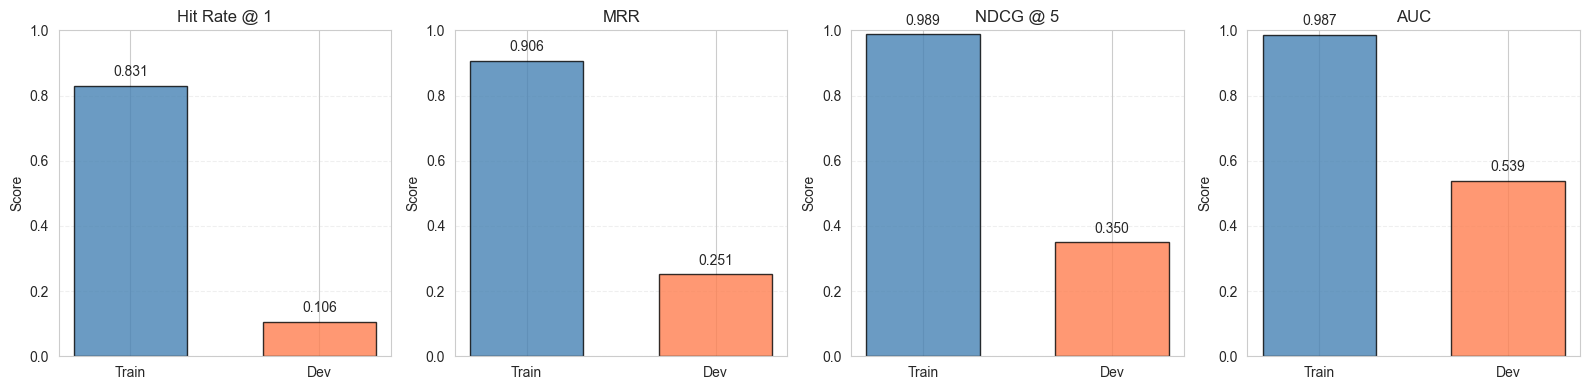

In [220]:
# Create comparison
comparison_df = pd.DataFrame({
    'Metric': ['Hit Rate @ 1', 'MRR', 'NDCG @ 5', 'AUC', 'Coverage'],
    'Train': [train_metrics['Hit Rate @ 1'], train_metrics['MRR'], train_metrics['NDCG @ 5'], 
              train_metrics['AUC'], train_metrics['Coverage']],
    'Dev': [dev_metrics['Hit Rate @ 1'], dev_metrics['MRR'], dev_metrics['NDCG @ 5'], 
            dev_metrics['AUC'], dev_metrics['Coverage']]
})
comparison_df['Difference'] = comparison_df['Train'] - comparison_df['Dev']
comparison_df['Relative Diff %'] = ((comparison_df['Train'] - comparison_df['Dev']) / comparison_df['Train'] * 100).round(2)

print("Train vs Dev Comparison:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
metrics_to_plot = ['Hit Rate @ 1', 'MRR', 'NDCG @ 5', 'AUC']

for i, metric in enumerate(metrics_to_plot):
    train_val = comparison_df[comparison_df['Metric'] == metric]['Train'].values[0]
    dev_val = comparison_df[comparison_df['Metric'] == metric]['Dev'].values[0]
    
    axes[i].bar(['Train', 'Dev'], [train_val, dev_val], width=0.6, 
                color=['steelblue', 'coral'], alpha=0.8, edgecolor='black')
    axes[i].set_ylabel('Score')
    axes[i].set_title(metric)
    axes[i].set_ylim([0, 1.0])
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')
    axes[i].text(0, train_val + 0.02, f'{train_val:.3f}', ha='center', va='bottom')
    axes[i].text(1, dev_val + 0.02, f'{dev_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
